In [2]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
from typing import Final
from matplotlib import rcParams

plt.style.use("default")
COLOR = 'black'

# FIGURE & AXES
rcParams['figure.figsize'] = (15,10)
rcParams['figure.dpi'] = 70
rcParams['axes.grid'] = True
# rcParams['axes.xmargin'] = 0
rcParams['axes.labelcolor'] = COLOR
rcParams['axes.facecolor'] = '#ebebeb'
rcParams['axes.grid.axis'] = 'both'
rcParams['axes.axisbelow'] = True
rcParams['text.color'] = COLOR
rcParams['text.color'] = COLOR
rcParams['xtick.color'] = COLOR
rcParams['ytick.color'] = COLOR
rcParams['grid.color'] = COLOR


# FONT
rcParams["font.family"] = "serif"
rcParams["mathtext.fontset"] = "cm"
rcParams['axes.titlesize'] = 36
rcParams['axes.labelsize'] = 36
rcParams['ytick.labelsize'] = 22
rcParams['xtick.labelsize'] = 22
rcParams['legend.fontsize'] = 28
rcParams['legend.title_fontsize'] = 28

rcParams['text.latex.preamble'] = "\n".join([
    r'\usepackage[version=3]{mhchem}'
])

# SAVE
# rcParams['savefig.format'] = 'pdf'
rcParams['savefig.bbox'] = 'tight'
# rcParams['savefig.pad_inches'] = 0.05
CALIBRATION: Final[float] = 1.362 # [px/µm]

def binarize_image(image, threshold, show=False):

    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)

    # Show the original and binarized images
    if show:
        cv2.imshow('Original Image', image)
        cv2.imshow('Binarized Image', binary_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return binary_image

def get_canny_edges(binary_image, show = False):
    edges = cv2.Canny(binary_image, 100, 200)  # Adjust the threshold values as needed
    if show:
        cv2.imshow('Detected edges', edges)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return edges

def rotate_image(image, angle, show = False):    
    # Get image dimensions
    height, width = image.shape[:2]
    
    # Calculate the rotation matrix
    rotation_matrix = cv2.getRotationMatrix2D((width / 2, height / 2), angle, 1)
    
    # Apply rotation to the image
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height))
    
    if show:
        # Show the original and rotated images
        cv2.imshow('Original Image', image)
        cv2.imshow('Rotated Image', rotated_image)
        cv2.waitKey(0)
        cv2.destroyAllWindows()
    return rotated_image

def cortar(image, limites):
    # lee en gris
    min_x, max_x, min_y, max_y = limites
    first_cut = image[:max_y, :max_x]
    second_cut = first_cut[min_y:, min_x:]

    return second_cut

([], [])

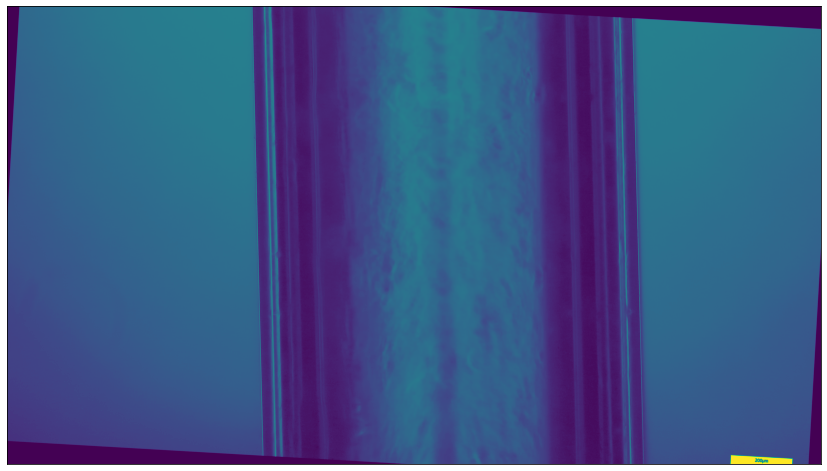

In [5]:
image_path = 'images/raw/C4-diam-5x-1Light.jpg'  # Replace 'example_image.jpg' with the path to your image
threshold_value = 200  # Threshold value (0-255)
rotation_angle = -3.30  # Rotation angle in degrees
calibration = 1.362 # [px/µm]
#fimg = get_canny_edges(rotate_image(binarize_image(image_path, threshold_value), rotation_angle))
gray_img = rotate_image(
    image=cv2.cvtColor(
        cv2.imread(image_path), 
        cv2.COLOR_BGR2GRAY
    ),
    angle=rotation_angle
)

plt.imshow(gray_img)
plt.grid()
plt.xticks([])
plt.yticks([])

### Maquina de hacer chorizos

Radio de C1
747.7922173274561 0.13627739043719977
Radio de C2
621.8795888399467 0.21279554693378416
Radio de C3
933.5704845814963 7.7349746003896795
Radio de C4
658.1057268722482 3.1797841146956327
Radio de C5
756.3942731277556 15.263076117139294


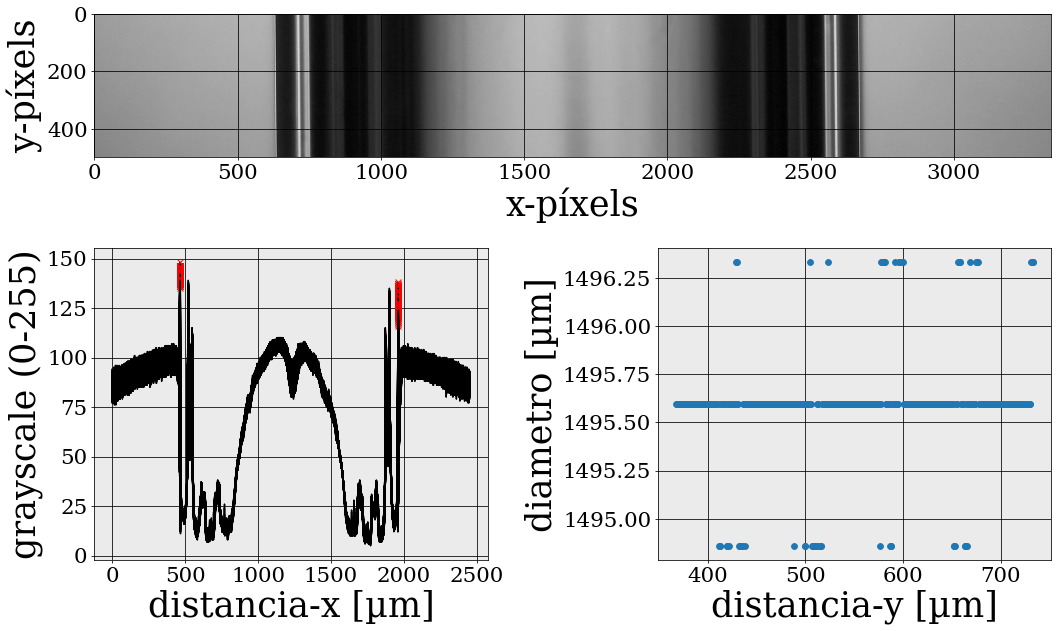

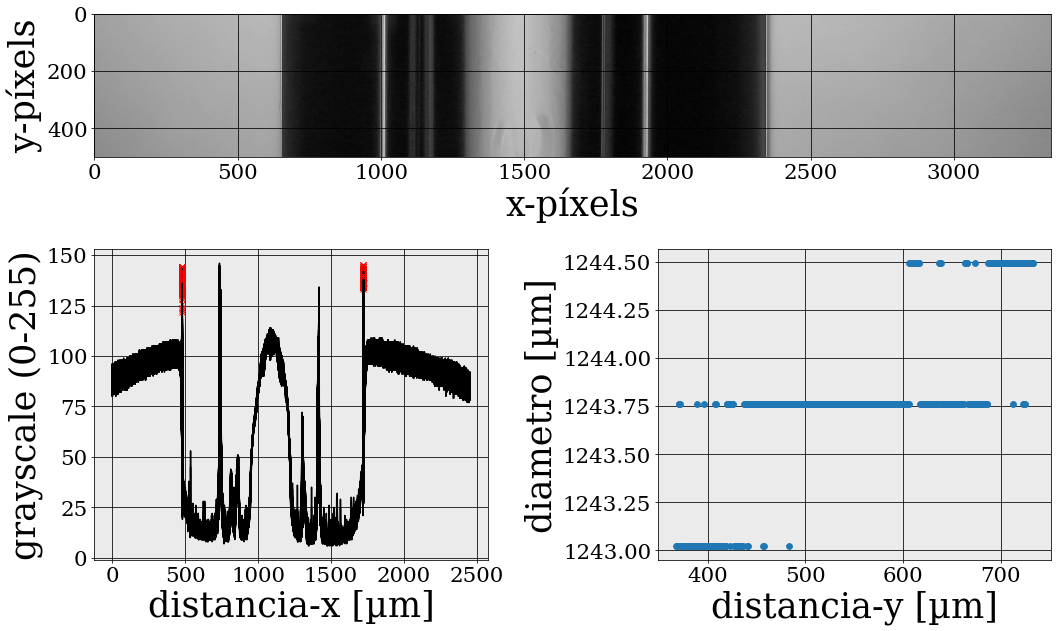

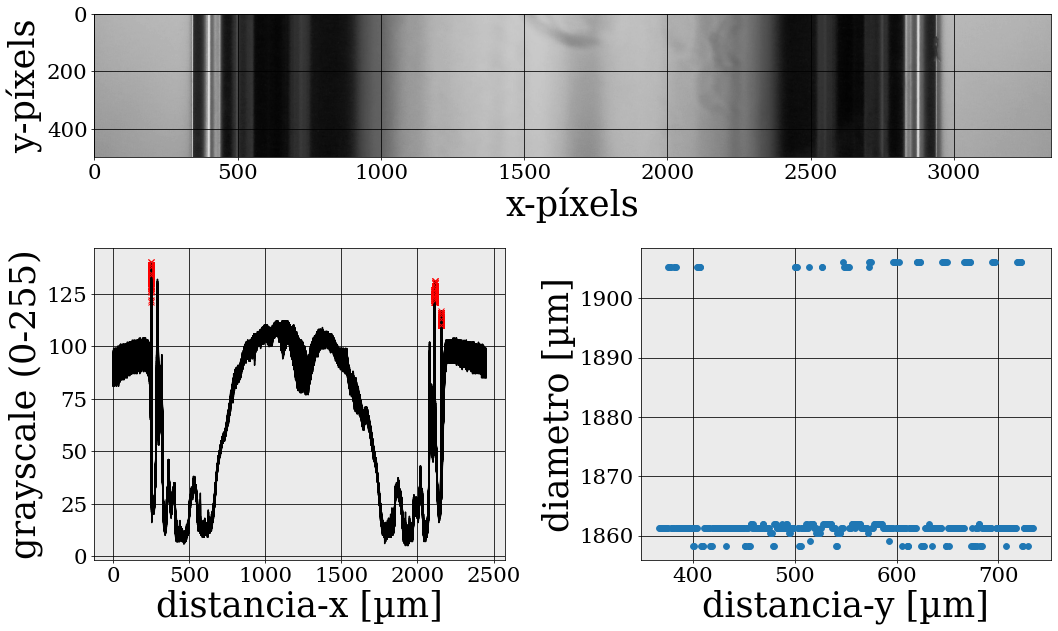

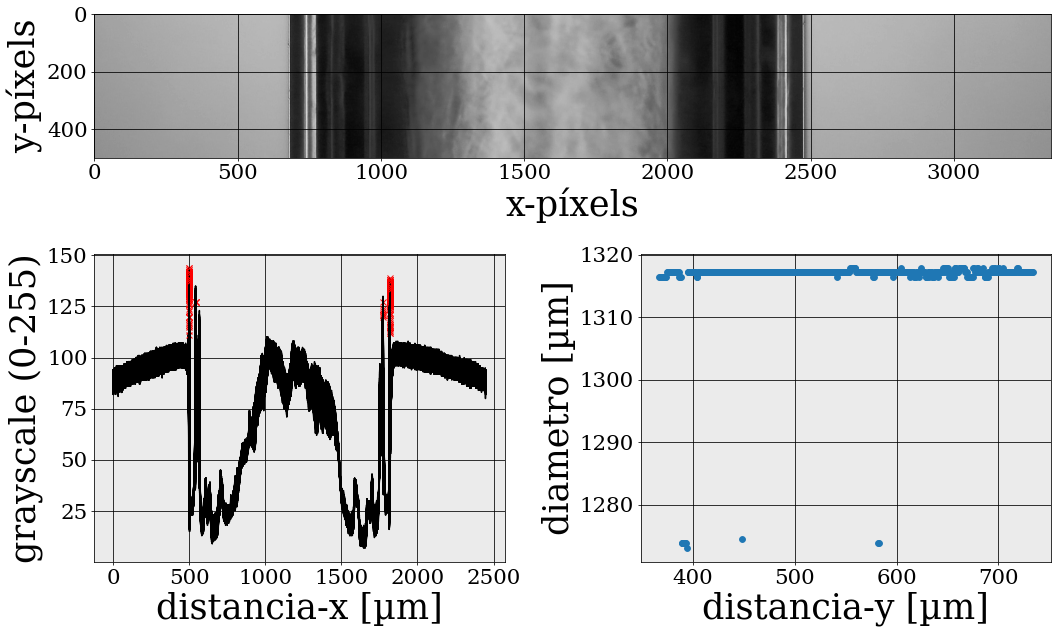

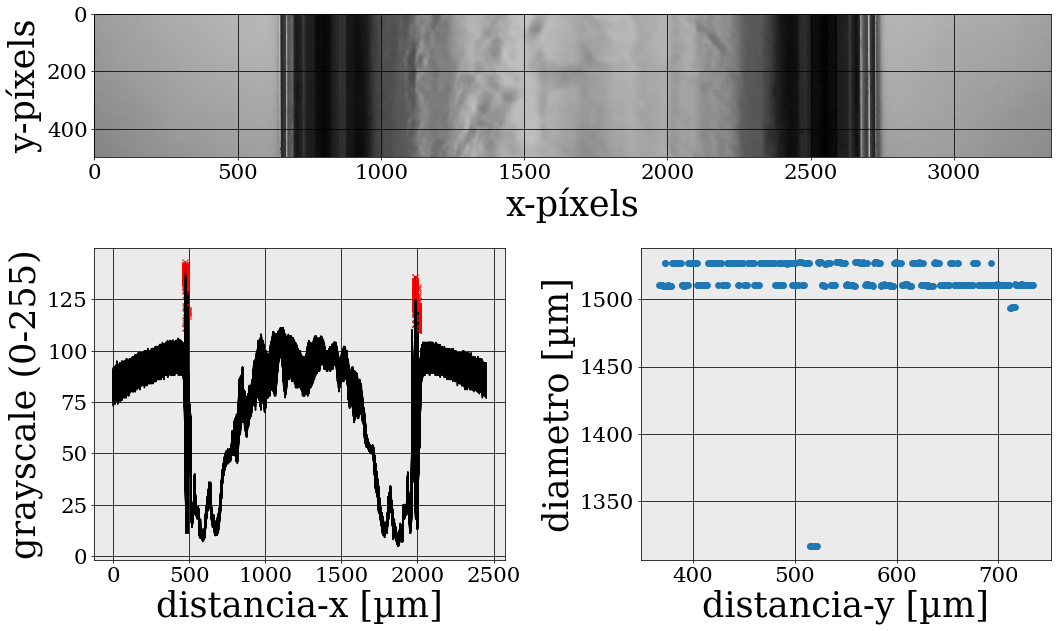

In [59]:
vertical_resolution = 2160 # la resolución vertical de nuestras imagenes - 500
rot_arr = -1*np.array([3.85,3.30,3.50,4.60,4.40]) # C1,...,C5
calibration = 1.362 # px/µm
threshold_value = 127

vmin = 500
vmax = 1000
yd_array = np.arange(vmin,1000) #agarro un corte vertical
diam_array = np.empty(yd_array.size, dtype="object") #mi array de diametros va a tener a lo sumo yd_array.size valores

for n,alpha in enumerate(rot_arr):
    
    fig = plt.figure(constrained_layout=True)
    gs = fig.add_gridspec(2,2)
    ax1 = fig.add_subplot(gs[1,0])
    ax2 = fig.add_subplot(gs[1,1])
    ax3 = fig.add_subplot(gs[0,:])

    
    img_path = 'images/raw/C'+str(n+1)+'-diam-5x-1Light.jpg'
    #roto la imagen en escala de grises
    gray_img = rotate_image(
        image = cv2.cvtColor(
            cv2.imread(img_path), 
            cv2.COLOR_BGR2GRAY
        ),
        angle = alpha
    )
    
    ax3.imshow(gray_img[vmin:1000,500:], cmap='gray')
    ax3.set_xlabel('x-píxels')
    ax3.set_ylabel('y-píxels')
    
    #por cada índice de mi corte vertical
    for i in yd_array:
        y = gray_img[i,500:]
        x = np.arange(y.size)/calibration
        y_left = y[:y.size//2] #tomamos hasta la mitad no inclusive
        y_right = y[y.size//2:] #tomamos de la mitad
        x_left_peak = find_peaks(y_left, height=110, width=2)[0]
        x_right_peak = find_peaks(y_right, height=110, width=2)[0]
        
        if x_left_peak.size!=0 and x_right_peak.size!=0:
            xpeak_array = np.array([x_left_peak[0],
                                    x_right_peak[-1] + y.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
            ypeak_array = np.array([y[xpeak_array[0]],
                                    y[xpeak_array[1]]])
            diam_array[i - vmin] = (xpeak_array[1] - xpeak_array[0])/calibration #le restamos vmin al índice para q empiece en 0

        ax1.plot(x,y,color='k')
        ax1.plot(xpeak_array/calibration,ypeak_array,'x',color='r')
    
    print("Radio de C"+str(n+1))
    print(np.average(diam_array)/2,np.std(diam_array)/2)
    
    ax2.plot(yd_array/calibration, diam_array, 'o', color='tab:blue')
    
    ax2.set_ylabel('diametro [µm]')
    ax2.set_xlabel('distancia-y [µm]')
    ax1.set_xlabel('distancia-x [µm]')
    ax1.set_ylabel('grayscale (0-255)')

Diámetro de C2
1243.7591776798934 0.4255910938675683


Text(0, 0.5, 'grayscale (0-255)')

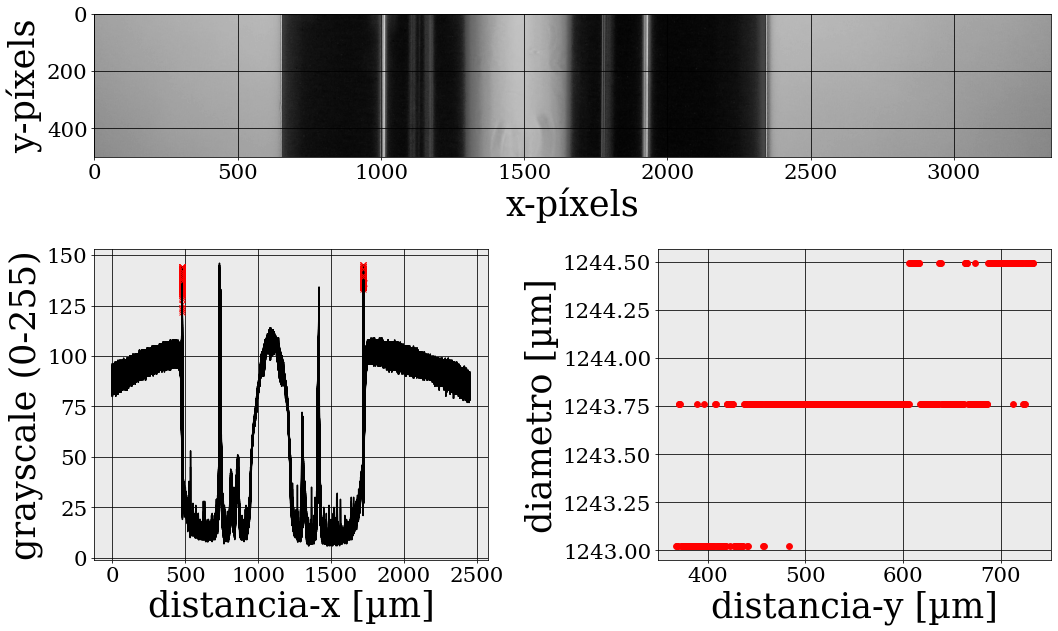

In [63]:
vertical_resolution = 2160 # la resolución vertical de nuestras imagenes - 500
rot_arr = -1*np.array([3.85,3.30,3.50,4.60,4.40]) # C1,...,C5
calibration = 1.362 # px/µm
threshold_value = 127

vmin = 500
vmax = 1000
yd_array = np.arange(vmin,1000) #agarro un corte vertical
diam_array = np.empty(yd_array.size, dtype="object") #mi array de diametros va a tener a lo sumo yd_array.size valores
    
fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(2,2)
ax1 = fig.add_subplot(gs[1,0])
ax2 = fig.add_subplot(gs[1,1])
ax3 = fig.add_subplot(gs[0,:])


img_path = 'images/raw/C'+str(2)+'-diam-5x-1Light.jpg'
#roto la imagen en escala de grises
gray_img = rotate_image(
    image = cv2.cvtColor(
        cv2.imread(img_path), 
        cv2.COLOR_BGR2GRAY
    ),
    angle = rot_arr[1]
)

ax3.imshow(gray_img[vmin:1000,500:], cmap='gray')
ax3.set_xlabel('x-píxels')
ax3.set_ylabel('y-píxels')

#por cada índice de mi corte vertical
for i in yd_array:
    y = gray_img[i,500:]
    x = np.arange(y.size)/calibration
    y_left = y[:y.size//2] #tomamos hasta la mitad no inclusive
    y_right = y[y.size//2:] #tomamos de la mitad
    x_left_peak = find_peaks(y_left, height=110, width=2)[0]
    x_right_peak = find_peaks(y_right, height=110, width=2)[0]
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xpeak_array = np.array([x_left_peak[0],
                                x_right_peak[-1] + y.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array([y[xpeak_array[0]],
                                y[xpeak_array[1]]])
        diam_array[i - vmin] = (xpeak_array[1] - xpeak_array[0])/calibration #le restamos vmin al índice para q empiece en 0

    ax1.plot(x,y,color='k')
    ax1.plot(xpeak_array/calibration,ypeak_array,'x',color='r')

print("Diámetro de C"+str(2))
print(np.average(diam_array),np.std(diam_array))

ax2.plot(yd_array/calibration, diam_array, 'o', color='r')

ax2.set_ylabel('diametro [µm]')
ax2.set_xlabel('distancia-y [µm]')
ax1.set_xlabel('distancia-x [µm]')
ax1.set_ylabel('grayscale (0-255)')

## Filamentos

3840 2160
Diámetro de filamento
1024.1459618208517 4.806922741131286
Radio de filamento
512.0729809104258 2.403461370565643


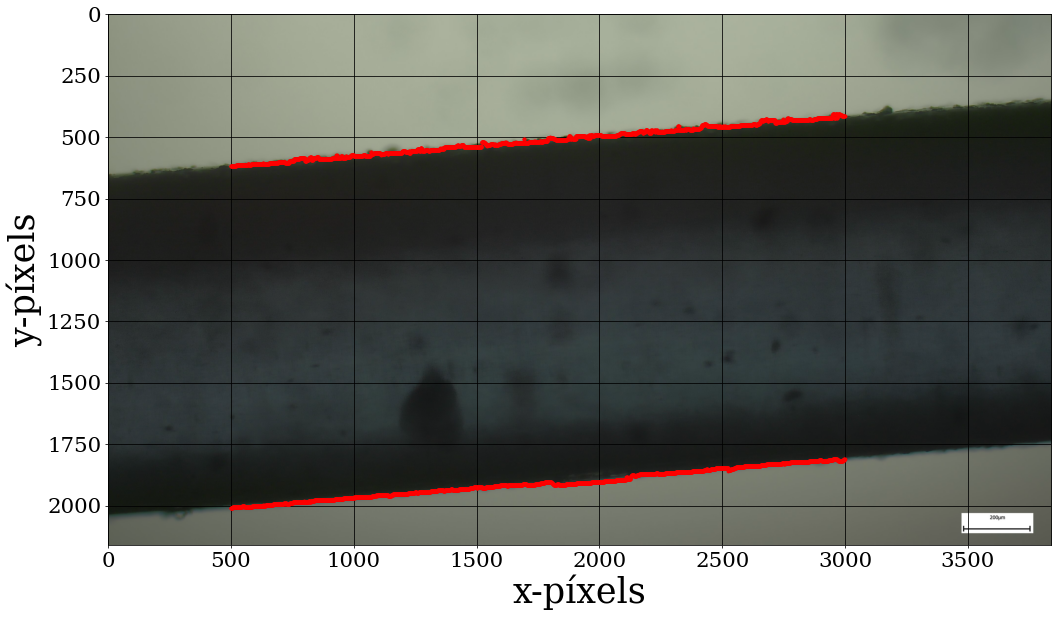

In [38]:
img_path = './E0020_006.jpg'
gray_img = binarize_image(
    image=cv2.cvtColor(
        cv2.imread(img_path), 
        cv2.COLOR_BGR2GRAY),
    threshold=80
)
xsize = gray_img[0,:].size
ysize = gray_img[:,0].size

print(xsize,ysize)

diam_array = np.array([])

fig = plt.figure(constrained_layout=True)
gs = fig.add_gridspec(1,1)

ax1 = fig.add_subplot(gs[0,0])

image = cv2.imread(img_path)

ax1.imshow(image)
ax1.set_xlabel('x-píxels')
ax1.set_ylabel('y-píxels')

#por cada índice de mi corte vertical
for i in np.arange(500,3000):
    vslice = gray_img[:,i]
    x = np.arange(vslice.size)/CALIBRATION
    
    y_left = vslice[:vslice.size//2] #tomamos hasta la mitad no inclusive
    y_right = vslice[vslice.size//2:] #tomamos de la mitad
    x_left_peak = np.argwhere(y_left==255)
    x_right_peak = np.argwhere(y_right==255)
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xl = x_left_peak[-1]
        xr = x_right_peak[0]
        xpeak_array = np.array([xl, xr + vslice.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array((i,i))
        diam_array = np.append(diam_array,(xpeak_array[1] - xpeak_array[0])/CALIBRATION)
        ax1.plot(ypeak_array,xpeak_array,'.',color='r')

print("Diámetro de filamento")
print(np.average(diam_array),np.std(diam_array))

print("Radio de filamento")
print(np.average(diam_array)/2,np.std(diam_array)/2)

# ax2.set_xlabel('distancia-x [µm]')
# ax2.set_ylabel('distancia-y [µm]')


Diametro de filamento
1022.0014684287811 5.182703045533195
Radio de filamento
511.00073421439055 2.5913515227665975


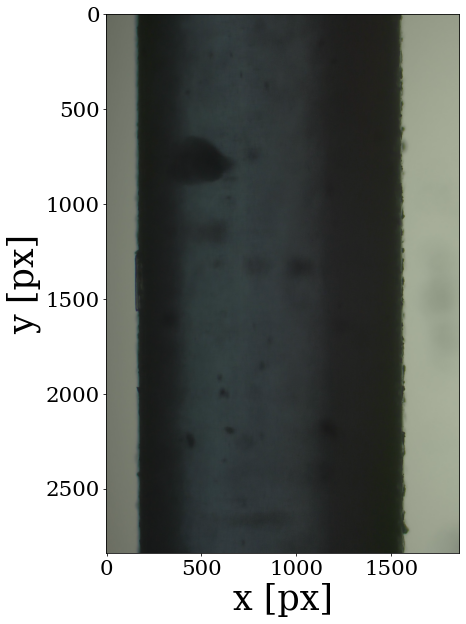

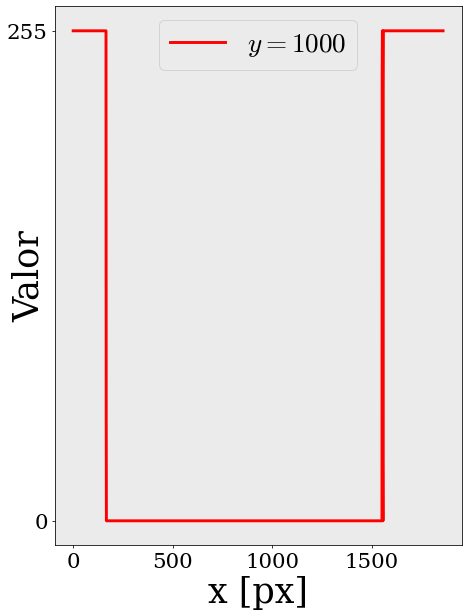

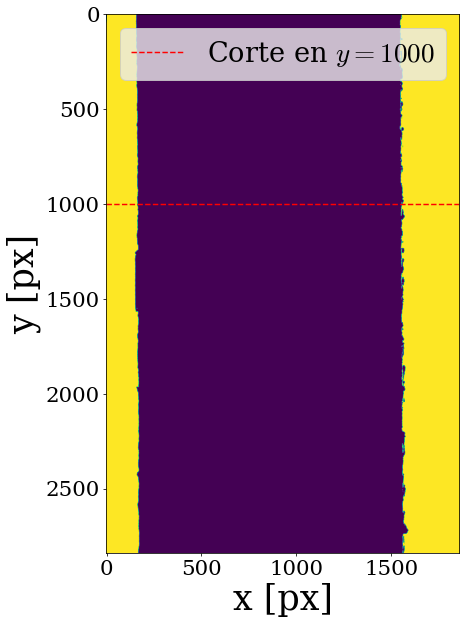

In [150]:
img_path = 'E0020_006.jpg'
im = rotate_image(binarize_image(
    image=cv2.cvtColor(
        cv2.imread(img_path), 
        cv2.COLOR_BGR2GRAY),
    threshold=80
),angle=-4.3)

full_image = rotate_image(cv2.rotate(cv2.imread(img_path), cv2.ROTATE_90_CLOCKWISE),angle=-4.3)[500:-500,100:-200]
fig, ax = plt.subplots()

fig1, ax1 = plt.subplots(figsize=(7.5,10))

fig, ax2 = plt.subplots()

xsize = im[0,:].size
ysize = im[:,0].size
min_vslice = 500
max_vslice = 3000

diam_array = np.array([])

im_rot = cv2.rotate(im, cv2.ROTATE_90_CLOCKWISE)[500:-500,100:-200]

ax.imshow(full_image)
ax1.plot(im_rot[1000,:], lw=3, color='r', label='$y=1000$')
ax2.imshow(im_rot)
ax2.axhline(1000, color='r', ls='--', label='Corte en $y=1000$')


for i in np.arange(min_vslice, max_vslice):
    vslice = im[:,i].T
#for i, vslice in enumerate( im[:, min_vslice:max_vslice].T ):
    
    y_left = vslice[:vslice.size//2] #tomamos hasta la mitad no inclusive
    y_right = vslice[vslice.size//2:] #tomamos de la mitad
    x_left_peak = np.argwhere(y_left==255)
    x_right_peak = np.argwhere(y_right==255)
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xl = x_left_peak[-1]

        xr = x_right_peak[0]
        xpeak_array = np.array([xl, xr + vslice.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array((i,i))
        diam_array = np.append(diam_array,(xpeak_array[1] - xpeak_array[0])/CALIBRATION)
        # ax.plot(ypeak_array,xpeak_array,'.',color='r')

#xy-labels
ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax1.set_xlabel('x [px]')
ax1.set_ylabel('Valor', labelpad = -40)
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')


#xy-ticks
ax1.set_yticks([0,255])
ax1.set_yticklabels(['0','255'])
ax1.set_xticks([0,500,1000,1500])


ax1.legend()
ax2.legend()

ax.grid()
ax1.grid()
ax2.grid()

print("Diametro de filamento")
print(np.average(diam_array),np.std(diam_array))
print("Radio de filamento")
print(np.average(diam_array)/2,np.std(diam_array)/2)


## Cabecillas

### Encontrando los límites correctos para la foto de la cabecilla

Diametro de cabecilla
931.8112151248164 4.838970143188088
Radio de cabecilla
465.9056075624082 2.419485071594044


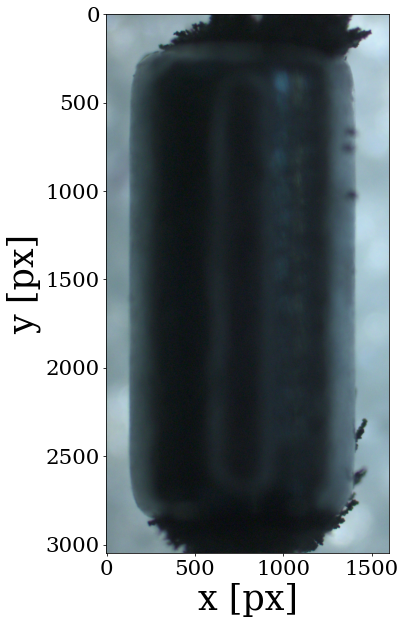

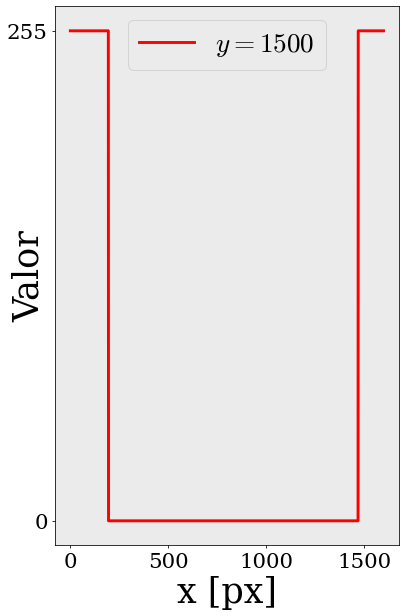

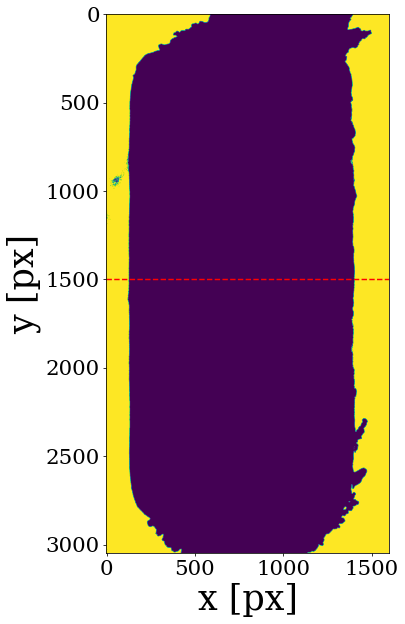

In [160]:
img_path = './cabecilla.png'

im_cut = cortar(
    image = rotate_image(
        image = cv2.imread(img_path),
        angle = 10
    ),
    limites = [350,3400,300,1900]
)

fig, ax = plt.subplots()

fig1, ax1 = plt.subplots(figsize=(6.35,10))

fig, ax2 = plt.subplots()

gray_image = cv2.cvtColor(im_cut, cv2.COLOR_BGR2GRAY)
im = binarize_image(gray_image,135)
im_rot = cv2.rotate(im_cut, cv2.ROTATE_90_CLOCKWISE)

xsize = im[0,:].size
ysize = im[:,0].size
min_vslice = 500
max_vslice = 2100

diam_array = np.array([])

ax.imshow(im_rot)
ax1.plot(im[:,1500].T, lw=3, color='r', label='$y=1500$')
ax2.axhline(1500, color='r', ls='--', label='Corte en $y=1500$')
ax2.imshow(cv2.rotate(im,cv2.ROTATE_90_CLOCKWISE))

for i in np.arange(min_vslice, max_vslice):
    vslice = im[:,i].T
#for i, vslice in enumerate( im[:, min_vslice:max_vslice].T ):
    
    y_left = vslice[:vslice.size//2] #tomamos hasta la mitad no inclusive
    y_right = vslice[vslice.size//2:] #tomamos de la mitad
    x_left_peak = np.argwhere(y_left==255)
    x_right_peak = np.argwhere(y_right==255)
    
    if x_left_peak.size!=0 and x_right_peak.size!=0:
        xl = x_left_peak[-1]

        xr = x_right_peak[0]
        xpeak_array = np.array([xl, xr + vslice.size//2]) # volvemos a ponerle la mitad del índice que le sacamos
        ypeak_array = np.array((i,i))
        diam_array = np.append(diam_array,(xpeak_array[1] - xpeak_array[0])/CALIBRATION)
        # ax.plot(ypeak_array,xpeak_array,'.',color='r')

ax1.set_yticks([0,255])
ax1.set_yticklabels(['0','255'])

ax.set_xlabel('x [px]')
ax.set_ylabel('y [px]')
ax1.set_xlabel('x [px]')
ax1.set_ylabel('Valor', labelpad = -40)
ax2.set_xlabel('x [px]')
ax2.set_ylabel('y [px]')

legend_kwargs_ax1 = dict(loc="upper center", )

ax.grid()
ax1.legend(**legend_kwargs_ax1)
ax1.grid()
ax2.grid()

print("Diametro de cabecilla")
print(np.average(diam_array),np.std(diam_array))
print("Radio de cabecilla")
print(np.average(diam_array)/2,np.std(diam_array)/2)
